# Upper Confidence Bound (UCB)

### The Multi-Armed Bandit Problem

The **multi-armed bandit (MAB)** problem is a fundamental concept in reinforcement learning, and can be explained using the example of slot machines:
- **Scenario**: Imagine you're in a casino with several slot machines, each with different payout rates. You want to maximize your returns from a limited number of plays, but you don't know which machine has the best payout rate.
- This dilemma involves balancing two competing goals:
  - **Exploration**: trying different machines to learn or gather information about their payout rates, and
  - **Exploitation**: focusing on the machine that seems to offer the best payout based on what you've learned so far.
- The challenge lies in determining the optimal strategy to maximize your rewards over time by effectively balancing these two approaches.

Each machine represents an arm, and you're faced with choosing which arm to pull to maximize your reward over time. You don't know the payout distribution of any machine in advance, so you must decide when to take a risk on a new machine (**exploration**) or stick with the machine you think is the best (**exploitation**).

Interesting paper: [Using confidence bounds for exploitation-exploration trade-offs - Peter Auer](https://dl.acm.org/doi/10.5555/944919.944941).

### Upper Confidence Bound (UCB) Algorithm
The UCB approach to solving the multi-armed bandit problem works by balancing exploration and exploitation using the concept of "**confidence intervals**".
- It selects the machine with the highest upper bound on the estimated reward, considering both the average reward obtained from a machine and the uncertainty about that machine.
- As more plays are made, the algorithm becomes more confident about which machine is the best, and it exploits the most promising machine more frequently.

The UCB algorithm ensures that you gather enough information (**explore**) early on but gradually focus on the machine that appears to offer the highest reward (**exploit**). By doing this, UCB minimizes **regret**—the loss incurred from not choosing the best option from the start.

This concept is applicable beyond slot machines, including modern problems like online advertising, where a company might want to determine which ad variant is the most effective in real-time without wasting too much budget testing poor-performing ads.

### Understanding the Intuition Behind the UCB Algorithm



The **UCB algorithm** provides a systematic way to navigate the exploration-exploitation trade-off. Here's how it intuitively works:

1. **Initial Assumption**: Start by treating all machines equally since you have no prior information about their payout distributions. This means initially, you have no reason to prefer one machine over another.
  - In the image below, we see that the machine that gives us the most profit is the yellow one. However, at the beginning, we set the same average (red stripe) for all of them.

2. **Confidence Bands**: For each machine, the UCB algorithm calculates a confidence interval around the estimated average reward. This interval reflects both the observed performance (empirical average) and the uncertainty due to limited data (how much you've explored that machine).
  - Represented by the gray box in the image below.



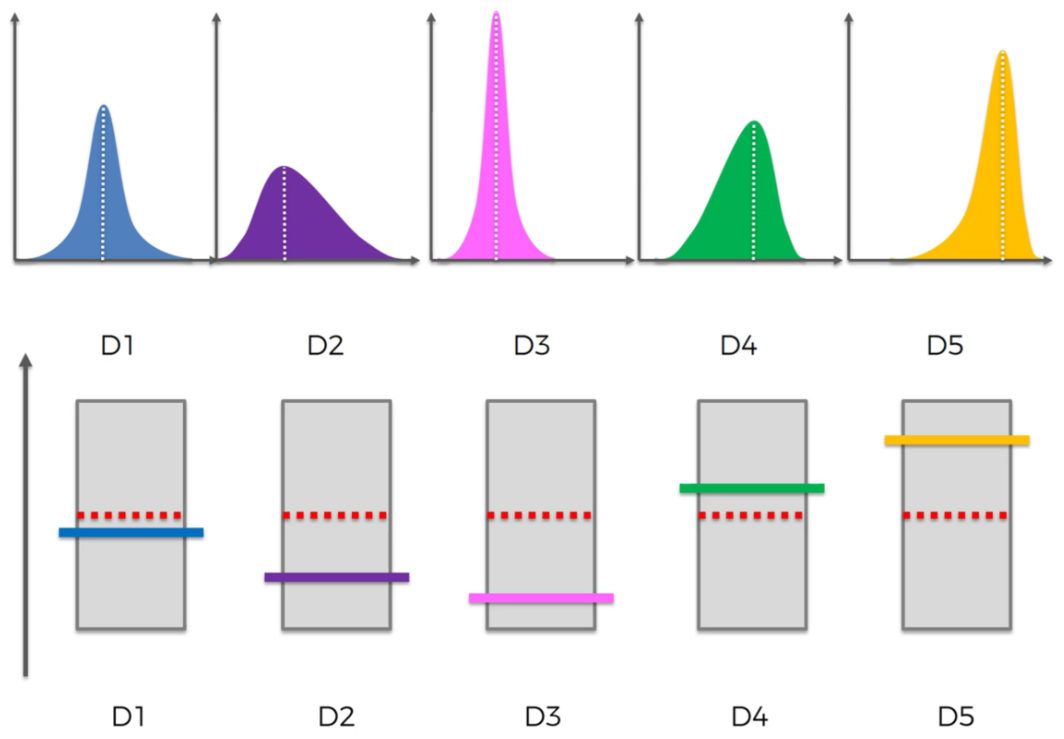


3. **Selection Strategy**: At each step (or "round"), the algorithm selects the machine with the highest upper confidence bound. This selection criterion ensures that:
   - **Exploration**: Machines with less data (wider confidence intervals) are more likely to be selected, promoting exploration.
   - **Exploitation**: Machines that have shown higher rewards are favored, promoting exploitation.

4. **Updating Beliefs**: After selecting a machine and observing the outcome (reward or no reward), the algorithm updates the empirical average and tightens the confidence interval for that machine. Over time, as more data is gathered:
   - The confidence intervals become narrower, reducing uncertainty.
   - The algorithm increasingly favors machines that consistently perform well.

This is the final result we obtain:

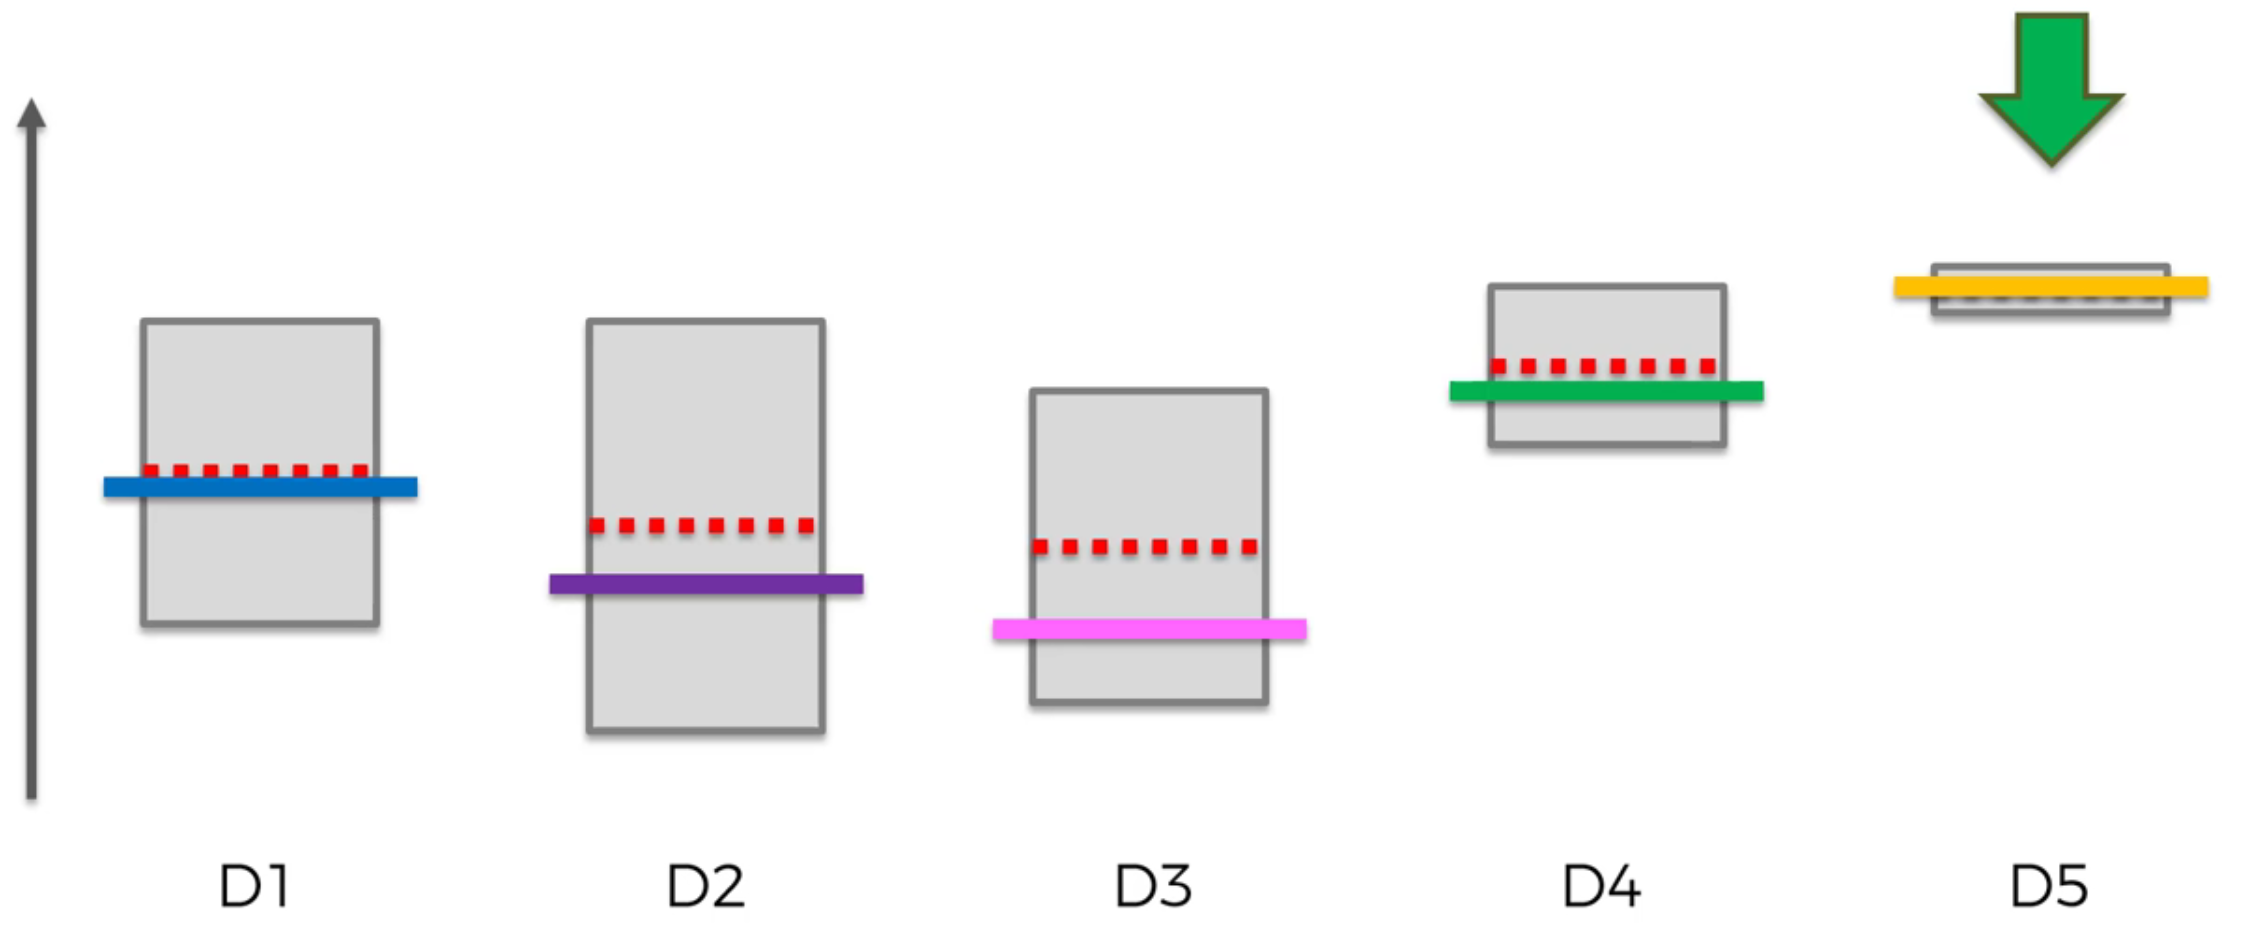

We can see that yellow has been one of the most explored, which is why its confidence limits (grey area) are so narrow.

Summary of the algorithm using formal notation:



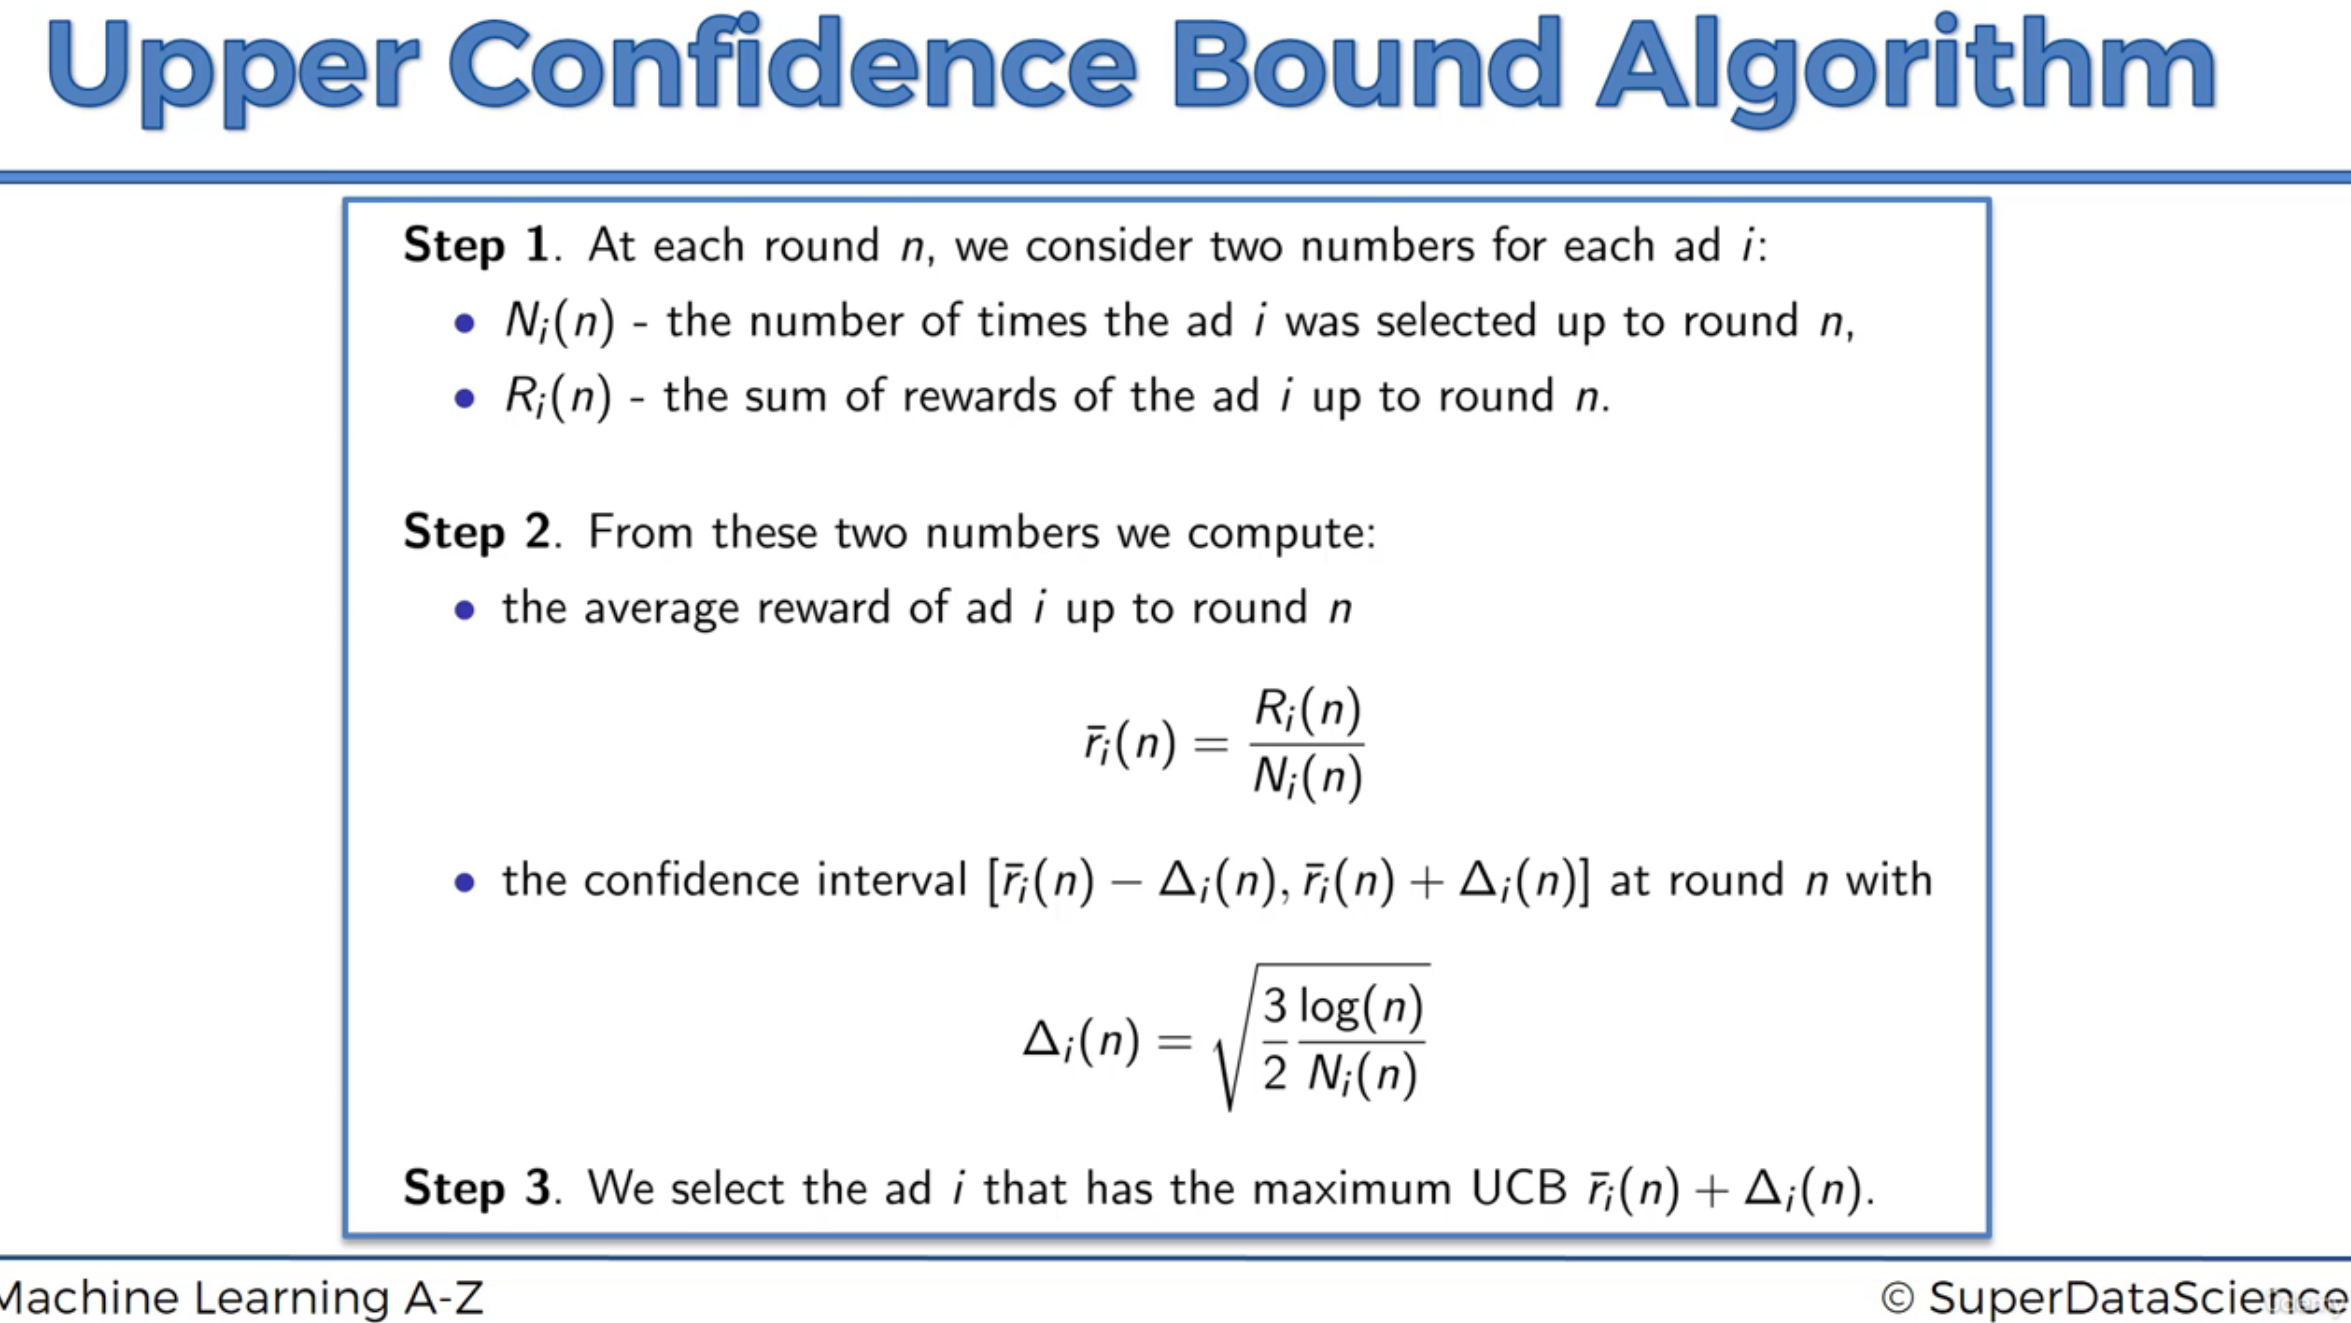

### Practical Application: Online Advertising

A modern application of the multi-armed bandit problem and the UCB algorithm is in **online advertising**. Suppose a company runs a campaign with multiple ad variants. The goal is to determine which ad performs best in real-time to maximize user engagement (e.g., clicks).

- **Arms**: Different ad variants.
- **Rewards**: Clicks (reward = 1) or no clicks (reward = 0).
- **Rounds**: Each time a user visits the webpage and an ad is displayed.

Using UCB, the algorithm dynamically selects which ad to display based on past performance while still exploring other ads to ensure the best one is identified and exploited effectively. This approach maximizes engagement from the onset of the campaign, avoiding the prolonged trial-and-error phase associated with traditional A/B testing.

### Key Takeaways

- **Balance Exploration and Exploitation**: UCB intelligently manages the trade-off by selecting actions that either explore uncertain options or exploit known rewarding ones.
- **Minimize Regret**: By efficiently balancing exploration and exploitation, UCB aims to minimize regret, which is the difference between the rewards actually received and the rewards that could have been received by always selecting the best option.
- **Adaptive Learning**: UCB continuously updates its confidence bounds, allowing it to adapt to new information and maintain optimal performance over time.

In essence, the Upper Confidence Bound algorithm offers a robust and mathematically grounded approach to making informed decisions in uncertain environments, making it a powerful tool in the reinforcement learning toolkit.

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

**Dataset description:**
- The dataset involves an online learning experiment for a car dealership trying to sell a new SUV. The goal is to optimize the click-through rate (CTR) of 10 different ad designs, which feature the SUV in various settings (e.g., a mountain, futuristic city, countryside, or even on the moon).

- The ads are shown to users on websites or search engines, and the system tracks whether each user clicks on the ad (recorded as "1" for a click and "0" for no click).
- The experiment will run for 10,000 users, and the aim is to identify which ad design attracts the most clicks and, potentially, leads to the most sales.

The ad testing process is dynamic and happens in real time, rather than with a static dataset collected over a period of time. Simulating this in real life—creating real ads and running a campaign—would be too costly and impractical. Instead, they use a simulated dataset, where each row represents a user and each column represents one of the 10 ads. The dataset indicates which ad each user would click on (marked with a "1") or not (marked with a "0").

This simulation allows testing algorithms like UCB to optimize ad selection, without running an actual ad campaign.





**Note**: a simple, naive algorithm could be used to collect basic statistics on which ad is clicked the most. However, this approach isn't ideal because showing ads incurs a cost. The goal is to determine the best-performing ad (the one that attracts the most clicks) as quickly as possible, minimizing the number of ad impressions or "rounds." Since users are shown ads one by one, each round represents an opportunity to optimize ad selection. To do this efficiently, stronger algorithms like UCB are needed.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning A-Z/Part 6 - Reinforcement Learning/1 Upper Confidence Bound (UCB)/Ads_CTR_Optimisation.csv')

## Implementing UCB

In [5]:
import math

# Define the number of rounds (users) and the number of different ads
N = 10000  # Total number of rounds (users to show ads to)
d = 10     # Total number of ads (options)

# Initialize lists to store the ads selected in each round, number of times each ad is selected, and the sum of rewards (clicks) for each ad
ads_selected = []  # To keep track of the ads selected in each round
numbers_of_selections = [0] * d  # To store how many times each ad has been selected. [0] * 10 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sums_of_rewards = [0] * d        # To store the sum of rewards (clicks) for each ad

# Initialize the total reward (total number of clicks across all rounds)
total_reward = 0

# Loop over each round (user)
for n in range(0, N):
  ad = 0 # Variable to store the index of the ad to be selected
  max_upper_bound = 0  # Variable to store the maximum upper confidence bound

  # Loop over each ad to calculate its upper confidence bound
  for i in range(0, d):

    # If the ad has been selected at least once
    if (numbers_of_selections[i] > 0):
      # Calculate the average reward (click-through rate) of the ad
      average_reward = sums_of_rewards[i] / numbers_of_selections[i]
      # Calculate the confidence interval (delta_i) for this ad
      delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
      # Calculate the upper confidence bound for this ad
      upper_bound = average_reward + delta_i
    else:
      upper_bound = 1e400  # If the ad has never been selected, assign a very large upper bound to ensure it gets selected

    # Select the ad with the highest upper confidence bound
    if (upper_bound > max_upper_bound):
      max_upper_bound = upper_bound
      ad = i  # Update the ad index to the current one

  # Append the selected ad to the list of selected ads
  ads_selected.append(ad)

  # Update the number of selections for the chosen ad
  numbers_of_selections[ad] = numbers_of_selections[ad] + 1

  # Get the reward (click) from the dataset for the selected ad in this round
  reward = dataset.values[n, ad]

  # Update the sum of rewards for the selected ad
  sums_of_rewards[ad] = sums_of_rewards[ad] + reward

  # Update the total reward (total number of clicks)
  total_reward = total_reward + reward


1. **Initialization**:
   - `N = 10000` and `d = 10`: showing ads to 10,000 users, with 10 different ads available.
   - Lists `numbers_of_selections` and `sums_of_rewards` are initialized to keep track of how many times each ad has been selected (count of the number of times an ad has been displayed, regardless of whether the user clicked on it or not) and the sum of rewards (clicks) each ad has received, respectively. Initially, both are set to zero for all ads.
   - `ads_selected` keeps track of which ad is selected in each round.

2. **Loop over each round**:
   - For each round (each user), the algorithm decides which ad to show by calculating an upper confidence bound (UCB) for each ad. The ad with the highest UCB is selected.
   - How to calculate UCB for each ad `i`:
     - If the ad has been selected at least once, the algorithm calculates its **average reward** (click-through rate) as `sums_of_rewards[i] / numbers_of_selections[i]`.
     - It also calculates a **confidence interval** (delta) using the formula `math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])`. This interval shrinks as more data is gathered, allowing UCB to balance between exploring new ads and exploiting ads that have performed well.
     - The **upper bound** is the sum of the average reward and the confidence interval. This ensures that ads with uncertain but potentially high rewards are still explored.
     - If an ad has never been selected, its upper bound is set to a very large number (`1e400`) to ensure it gets selected early on.
   
3. **Select the ad with the highest UCB**:
   - The algorithm selects the ad with the highest UCB and appends it to `ads_selected`.

4. **Update selection and rewards**:
   - After selecting the ad, the algorithm updates:
     - `numbers_of_selections`: the count of how many times the selected ad has been shown.
     - `sums_of_rewards`: the sum of the rewards (clicks) for the selected ad.
     - `total_reward`: the cumulative total of clicks across all rounds.

In summary, UCB helps find the best ad by exploring all options at first (due to large confidence bounds for untested ads) and then focusing on the ads that are performing well (exploitation) as more data is collected. The algorithm constantly refines its understanding of the ads' performance to maximize the total number of clicks.

We implemented UCB manually to understand its mechanics, including how it balances exploration (trying different ads) and exploitation (focusing on successful ads).

However, there are libraries like **MABWiser**, **SMPyBandits**, and **multi-armed-bandit** that provide ready-made implementations of UCB. Take into account that libraries offer quick solutions but lack the hands-on understanding and flexibility we get from manual coding.

## Visualising the results

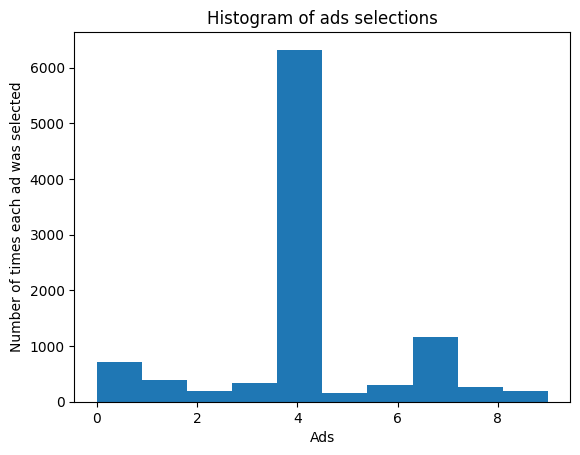

In [6]:
# Create a histogram of the ads selected by users
plt.hist(ads_selected) # Plot a histogram of the ads selected

plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

`ads_selected` serves as a complete record of ad choices made during the entire experiment, allowing for easy tracking and analysis of the selection process

In the histogram, the UCB algorithm shows one ad being selected significantly more than the others, so we can quickly identify the ad with the highest click-through rate (CTR).

Ad number five (index four) was indeed selected the most, indicating it had the highest CTR. This suggests that this particular ad features the most attractive image of the car, making it the most appealing to potential customers.

However, the goal is to determine how quickly the UCB algorithm can identify the ad with the highest click-through rate (CTR). Initially run with 10,000 rounds, the algorithm was effective in identifying the best ad.

Testing with fewer rounds, the algorithm successfully identified the best ad with 5,000 and even 1,000 rounds:




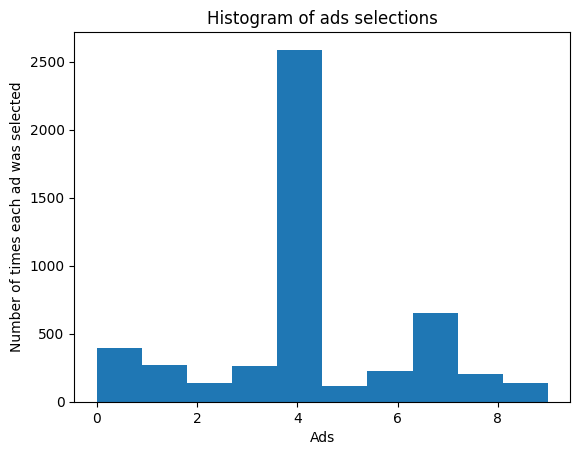

In [7]:
import math

N = 5000 # Testing with 5000 rounds
d = 10

ads_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d

total_reward = 0

for n in range(0, N):
  ad = 0
  max_upper_bound = 0

  for i in range(0, d):

    if (numbers_of_selections[i] > 0):
      average_reward = sums_of_rewards[i] / numbers_of_selections[i]
      delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
      upper_bound = average_reward + delta_i
    else:
      upper_bound = 1e400

    if (upper_bound > max_upper_bound):
      max_upper_bound = upper_bound
      ad = i

  ads_selected.append(ad)
  numbers_of_selections[ad] = numbers_of_selections[ad] + 1
  reward = dataset.values[n, ad]
  sums_of_rewards[ad] = sums_of_rewards[ad] + reward
  total_reward = total_reward + reward

plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

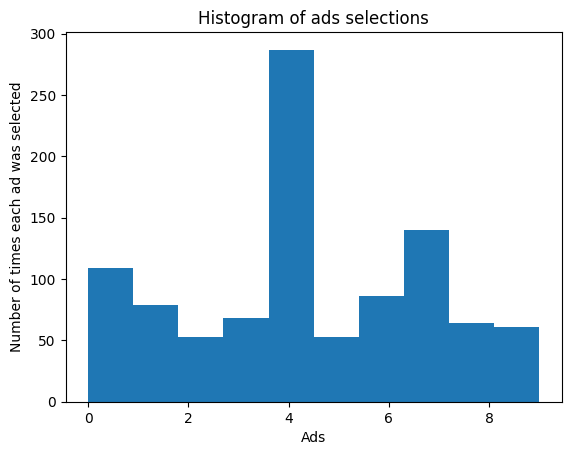

In [8]:
import math

N = 1000 # Testing with 1000 rounds
d = 10

ads_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d

total_reward = 0

for n in range(0, N):
  ad = 0
  max_upper_bound = 0

  for i in range(0, d):

    if (numbers_of_selections[i] > 0):
      average_reward = sums_of_rewards[i] / numbers_of_selections[i]
      delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
      upper_bound = average_reward + delta_i
    else:
      upper_bound = 1e400

    if (upper_bound > max_upper_bound):
      max_upper_bound = upper_bound
      ad = i

  ads_selected.append(ad)
  numbers_of_selections[ad] = numbers_of_selections[ad] + 1
  reward = dataset.values[n, ad]
  sums_of_rewards[ad] = sums_of_rewards[ad] + reward
  total_reward = total_reward + reward

plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

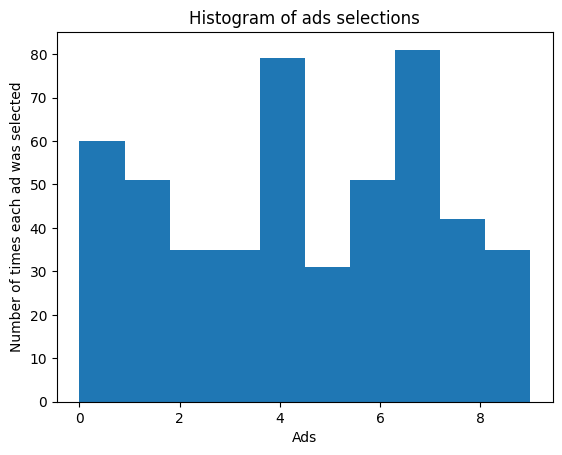

In [9]:
import math

N = 500 # Testing with 500 rounds
d = 10

ads_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d

total_reward = 0

for n in range(0, N):
  ad = 0
  max_upper_bound = 0

  for i in range(0, d):

    if (numbers_of_selections[i] > 0):
      average_reward = sums_of_rewards[i] / numbers_of_selections[i]
      delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
      upper_bound = average_reward + delta_i
    else:
      upper_bound = 1e400

    if (upper_bound > max_upper_bound):
      max_upper_bound = upper_bound
      ad = i

  ads_selected.append(ad)
  numbers_of_selections[ad] = numbers_of_selections[ad] + 1
  reward = dataset.values[n, ad]
  sums_of_rewards[ad] = sums_of_rewards[ad] + reward
  total_reward = total_reward + reward

plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

However, at 500 rounds, it failed to recognize the ad with the highest CTR (ad index four) and mistakenly identified ad index seven instead. This prompts an interest in comparing the UCB algorithm's performance with the Thompson sampling algorithm to see if it can identify the best ad in just 500 rounds.